In [1]:
import pymc as pm
from mc import *
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import arviz as az

In [2]:
%load_ext watermark
az.style.use("arviz-darkgrid")

In [3]:
out_path = f'out/dy_lo'
os.makedirs(out_path, exist_ok=True)

src = load_objectives(path_target='data/targets.json', exo={'p_comorb': 0.007})
model = src.build_model()

In [4]:
with model:
    fit = pm.sample_smc(draws=500, chains=3)
    ppost = pm.sample_posterior_predictive(fit)

Initializing SMC sampler...
Sampling 3 chains in 3 jobs


We recommend running at least 4 chains for robust computation of convergence diagnostics


In [5]:
az.summary(fit, kind="stats")

,mean,sd,hdi_3%,hdi_97%
p_comorb,0.244,0.139,0.020,0.473
rr_risk_comorb,17.675,7.353,4.457,29.373
beta_ds,13.150,2.590,8.718,17.752
rr_beta_dr,0.981,0.044,0.904,1.057
rr_inf_asym,0.364,0.199,0.040,0.734
rr_sus_ltbi,0.465,0.131,0.256,0.681
r_react,0.001,0.000,0.001,0.001
r_relapse_td,0.140,0.013,0.117,0.163
r_relapse_tc,0.032,0.003,0.027,0.038
r_relapse_st,0.002,0.000,0.001,0.002


/opt/conda/envs/pymc-dev/lib/python3.10/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (24), generating only 20 plots
  warnings.warn(


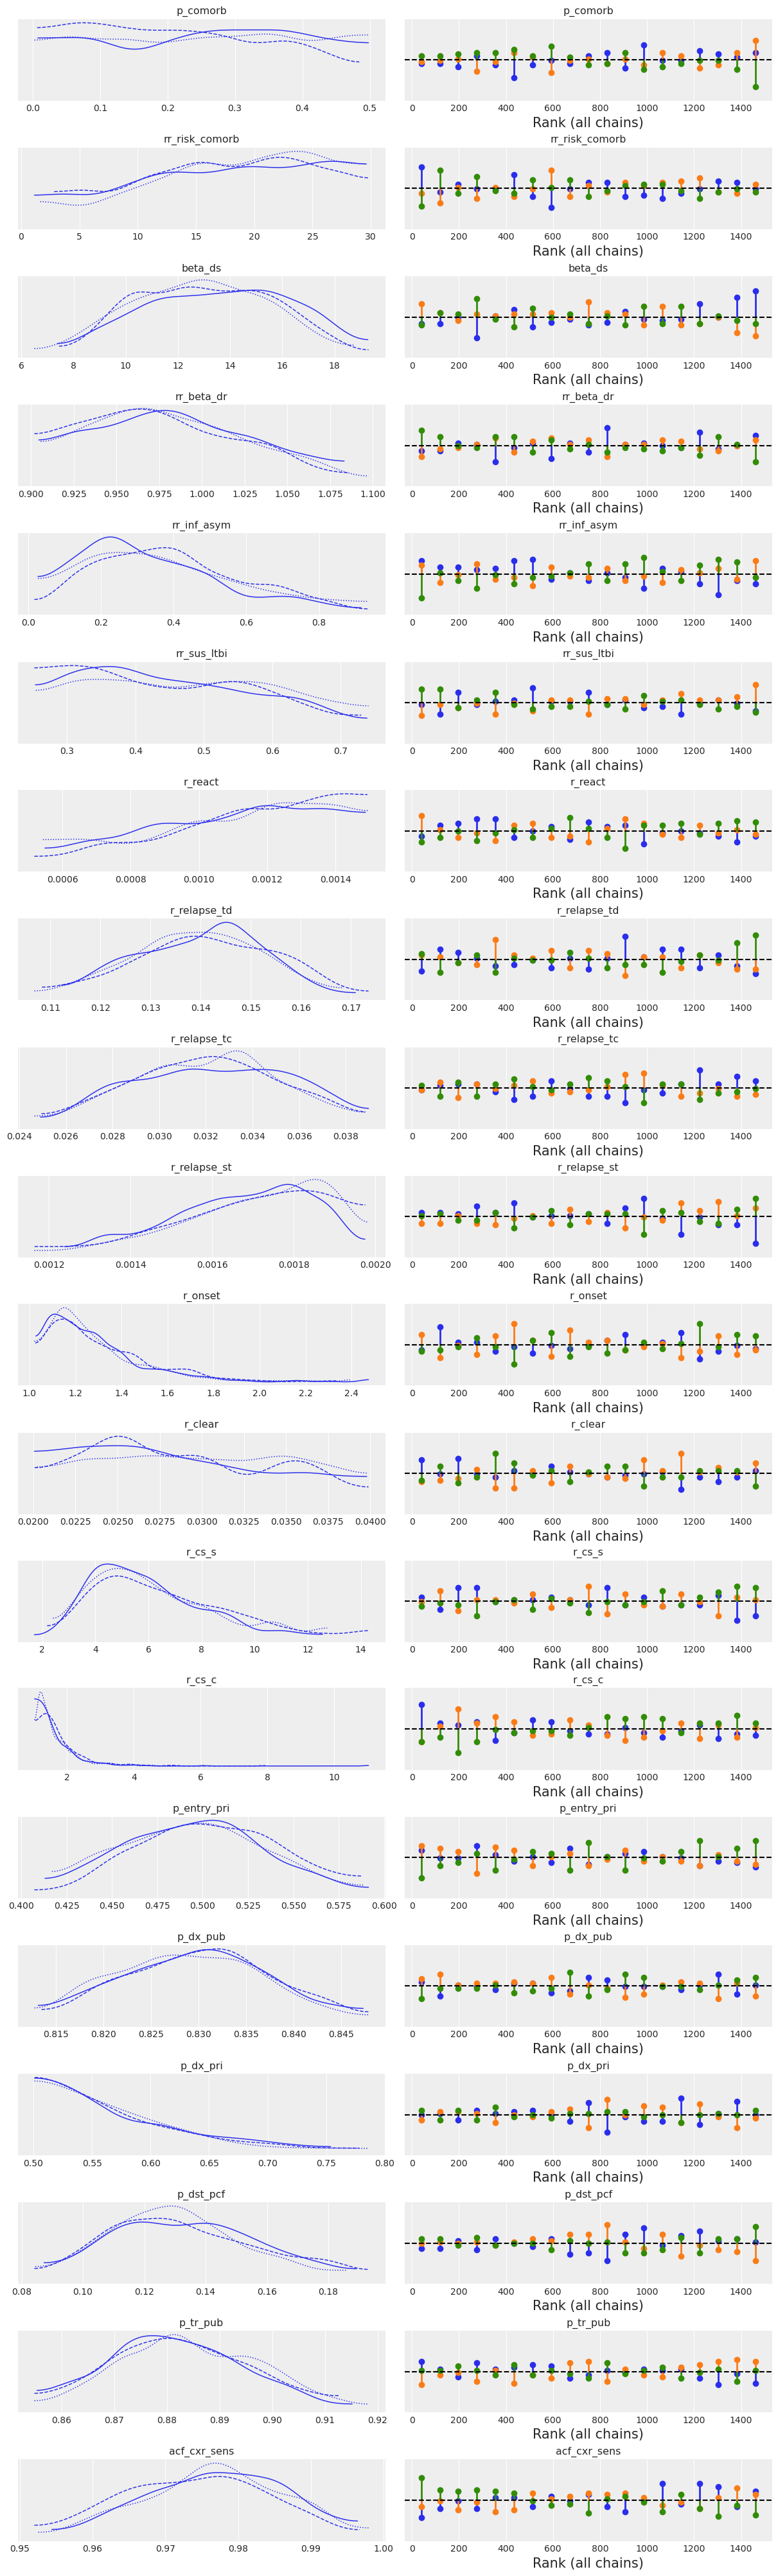

In [6]:
figs = az.plot_trace(fit, kind="rank_vlines")

In [7]:
posts = post_to_particles(fit)
posts = [src.serve(post) for post in posts]

with open(f'{out_path}/Post.json', 'w') as f:
    json.dump(posts, f)
        
# fit.to_netcdf(f'{out_path}/Post.nc')
# ppost.to_netcdf(f'{out_path}/Targets_Post.nc')

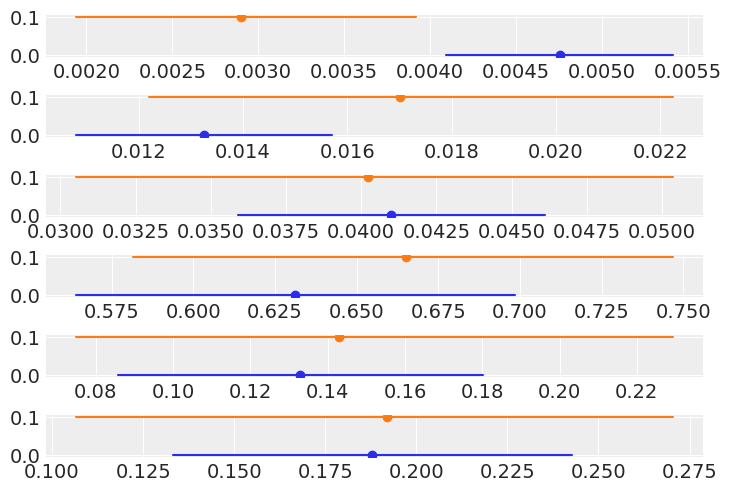

In [8]:
obs, eps = src.Obs, src.Eps

fig, ax = plt.subplots(nrows=6)


m = np.mean(ppost.posterior_predictive.sim.stack(samples=('chain', 'draw')), 1)
l = np.quantile(ppost.posterior_predictive.sim.stack(samples=('chain', 'draw')), 0.025, 1)
u = np.quantile(ppost.posterior_predictive.sim.stack(samples=('chain', 'draw')), 0.975, 1)

for i in range(6):
    ax[i].scatter(obs[i], 0)
    ax[i].plot([obs[i] - eps[i], obs[i] + eps[i]], [0, 0])
    
    ax[i].scatter(m[i], 0.1)
    ax[i].plot([l[i], u[i]], [0.1, 0.1])